[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sarwa\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Accuracy: 0.8266946016761005
Confusion Matrix:
 [[163081  36903]
 [ 32415 167577]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82    199984
           1       0.82      0.84      0.83    199992

    accuracy                           0.83    399976
   macro avg       0.83      0.83      0.83    399976
weighted avg       0.83      0.83      0.83    399976



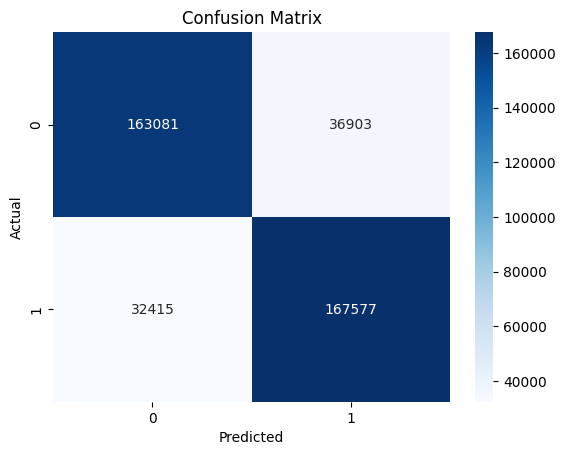

In [ ]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

# Step 1: Load Data
train_df = pd.read_csv("train.csv", header=None)
test_df = pd.read_csv("test.csv", header=None)
sample_df = pd.read_csv("sampled_train.csv", header=None)

# Add headers
train_df.columns = ['polarity', 'title', 'text']
test_df.columns = ['polarity', 'title', 'text']
sample_df.columns = ['polarity', 'title', 'text']

# Step 2: Combine columns for analysis
train_df['reviewText'] = train_df['title'] + " " + train_df['text']
test_df['reviewText'] = test_df['title'] + " " + test_df['text']
sample_df['reviewText'] = sample_df['title'] + " " + sample_df['text']

# Step 3: Data Cleaning
train_df = train_df.drop_duplicates(subset=['reviewText'])
test_df = test_df.drop_duplicates(subset=['reviewText'])
sample_df = sample_df.drop_duplicates(subset=['reviewText'])

train_df = train_df[['polarity', 'reviewText']]
test_df = test_df[['polarity', 'reviewText']]
sample_df = sample_df[['polarity', 'reviewText']]

# Map polarity labels
label_map = {1: 0, 2: 1}
train_df['polarity'] = train_df['polarity'].map(label_map)
test_df['polarity'] = test_df['polarity'].map(label_map)
sample_df['polarity'] = sample_df['polarity'].map(label_map)

train_df = train_df.dropna(subset=['reviewText'])
test_df = test_df.dropna(subset=['reviewText'])
sample_df = sample_df.dropna(subset=['reviewText'])

# Step 4: Text Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove numbers and punctuation
    text = text.lower()  # Lowercase
    text = text.split()  # Tokenization
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    return " ".join(text)

train_df['reviewText'] = train_df['reviewText'].apply(preprocess_text)
test_df['reviewText'] = test_df['reviewText'].apply(preprocess_text)
sample_df['reviewText'] = sample_df['reviewText'].apply(preprocess_text)

# Step 5: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_sample_train = tfidf.fit_transform(sample_df['reviewText'])
X_train = tfidf.transform(train_df['reviewText'])
X_test = tfidf.transform(test_df['reviewText'])

# Extract target labels
y_sample_train = sample_df['polarity'].values
y_train = train_df['polarity'].values
y_test = test_df['polarity'].values

# Step 6: Train and Update Model
model = MultinomialNB()
model.fit(X_sample_train, y_sample_train)
model.partial_fit(X_train, y_train, classes=np.unique(y_train))

# Step 7: Evaluate Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

# Step 8: Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Step 9: Topic Modeling with LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train)

# Display topics
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = " | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(f"Topik {topic_idx + 1}: {topic_words}")
        topics.append(f"Topik {topic_idx + 1}: {topic_words}")
    return topics

topics = display_topics(lda, tfidf.get_feature_names_out(), 10)

# Visualize topics
def visualize_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic in model.components_:
        words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_words.append(" | ".join(words))

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(topic_words)), model.components_.sum(axis=1), color='lightcoral')
    plt.yticks(range(len(topic_words)), [f"Topik {i+1}" for i in range(len(topic_words))])
    plt.xlabel("Word Importance")
    plt.title("Topik yang Sering Dibicarakan")
    plt.show()

visualize_topics(lda, tfidf.get_feature_names_out(), 10)

# Step 10: Save Model and Vectorizer
joblib.dump(tfidf, 'vectorizer.pkl')
joblib.dump(model, 'model.pkl')

print("Model and vectorizer have been saved.")

In [2]:
!pip install scikit-learn==1.6.0 

Defaulting to user installation because normal site-packages is not writeable
